## Data Cleaning

### Pump it Up: Data Mining the Water Table

#### HOSTED BY DRIVENDATA

"Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania."

Active competition until April 30, 2021, 11:59 p.m.

Distribution of labels, 3 possible values:

    functional - the waterpoint is operational and there are no repairs needed
    functional needs repair - the waterpoint is operational, but needs repairs
    non functional - the waterpoint is not operational

#### Data 

Only the data provided by the competition is permitted to be used. No outsourced data is allowed.

Competition data downloaded from: [Pump it Up Competition Webpage, hosted by DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/)

Find feature descriptions [here](../data/data_description.txt).

    X_training.csv - The independent variables for the training set
    y_training.csv - The dependent variable (status_group) for each of the rows in Training set values
    X_validate.csv - The independent variables that need predictions
    
-------------------- 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
X_training = pd.read_csv("../data/X_training.csv")
y_training = pd.read_csv("../data/y_training.csv")

In [3]:
print("X_training:")
display(X_training.head(3))
display(X_training.info())

X_training:


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

None

In [4]:
numeric = list(X_training.select_dtypes(np.number).columns)
categorical = list(X_training.select_dtypes('object').columns)

In [5]:
print("y_training:")
display(y_training.head(5))
display(y_training['status_group'].value_counts())
display(y_training['status_group'].value_counts(normalize=True))
y_training.isna().sum()

y_training:


,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

id              0
status_group    0
dtype: int64

### Inital Data Summary
Training set has 59,400 entries and 40 columns. Validation set has 14850 entries (25% hold out). All  Majority of features seem to be categorical on first inspection - need to investigate features values and distribution. There are scattered Null values to deal with and may be more (stored instead as placeholder values). There is a class imbalance for the well status target classes:

    54% are functional
    38% non-functional
    7.26% functional, needs repair
    
Consider inititially grouping third class in with another: can assist with original class imbalance if 'functional, needs repair' ('FNR') is grouped with 'non-functional' and then a secondary model sepertes those two. However, I think logically it would be better added to 'functional', since it does seem to *be* functional. And after splitting, then secondary classify the broad 'functional' category into 'working' and 'needs repair'. Could be solved by creating a hierarchical classification model.

Otherwise, up-sampling the minority class (with replacement) or down sampling the majority are options to address the imbalance, even if using the hierarchical model. 

Creating a balanced model is important to allow the model to be adequately exposed/trained on the rarer occurances ('FNR') instead of just skipping them. Being able to discern this small subgroup could be cost beneficial - repairing a functional well may be faster or less expensive than the overhaul required on a non-functional waterpoint. Repairing these waterpoints could have a different approach.

--------------------

In [6]:
df_train = pd.merge(X_training, y_training, on='id')
df_train.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional


---------
### Numeric Category Distribution

In [7]:
X_training[numeric].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [8]:
# examine value counts for numeric
for col in numeric:
    print(f"----- {col} -----")
    print(f"Unique: {X_training[col].nunique()}")
    try:
        display(X_training[col].value_counts()[0:10])
    except:
        display(X_training[col].value_counts())

----- id -----
Unique: 59400


2047     1
72310    1
49805    1
51852    1
62091    1
64138    1
57993    1
60040    1
33413    1
35460    1
Name: id, dtype: int64

----- amount_tsh -----
Unique: 98


0.0       41639
500.0      3102
50.0       2472
1000.0     1488
20.0       1463
200.0      1220
100.0       816
10.0        806
Name: amount_tsh, dtype: int64

----- gps_height -----
Unique: 2428


 0       20438
-15         60
-16         55
-13         55
-20         52
 1290       52
-14         51
 303        51
-18         49
-19         47
Name: gps_height, dtype: int64

----- longitude -----
Unique: 57516


0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
             ... 
37.579803       1
33.196490       1
34.017119       1
33.788326       1
30.163579       1
Name: longitude, Length: 57516, dtype: int64

----- latitude -----
Unique: 57517


-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

----- num_private -----
Unique: 65


0     58643
6        81
1        73
5        46
8        46
32       40
45       36
15       35
39       30
93       28
Name: num_private, dtype: int64

----- region_code -----
Unique: 27


11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
Name: region_code, dtype: int64

----- district_code -----
Unique: 20


1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
Name: district_code, dtype: int64

----- population -----
Unique: 1049


0      21381
1       7025
200     1940
150     1892
250     1681
300     1476
100     1146
50      1139
500     1009
350      986
Name: population, dtype: int64

----- construction_year -----
Unique: 55


0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
Name: construction_year, dtype: int64

- 'id' has no predictive power, there are no duplicatese
- 'num_private is almost entirely zero
- 'date_recorded' can be broken up into year, month (for seasonality)
- 'construction_year' is missing 20,000 pts, should be combined with 'date_recorded' to give an age of the pump
- 'amount_tsh' missing 41,639 values, drop
- A large proportion of zeros as placeholders/Null, proceed to imputing new values below

In [9]:
to_drop_numeric = ['num_private', 'amount_tsh']
# drop 'date_recorded' after transforming it, with categorical set of drops
(df_train[numeric] == 0).sum()

id                       1
amount_tsh           41639
gps_height           20438
longitude             1812
latitude                 0
num_private          58643
region_code              0
district_code           23
population           21381
construction_year    20709
dtype: int64

### Geographic Distribution

See expanded geographic analysis [here](../question_1_waterpoint_distribution.ipynb).

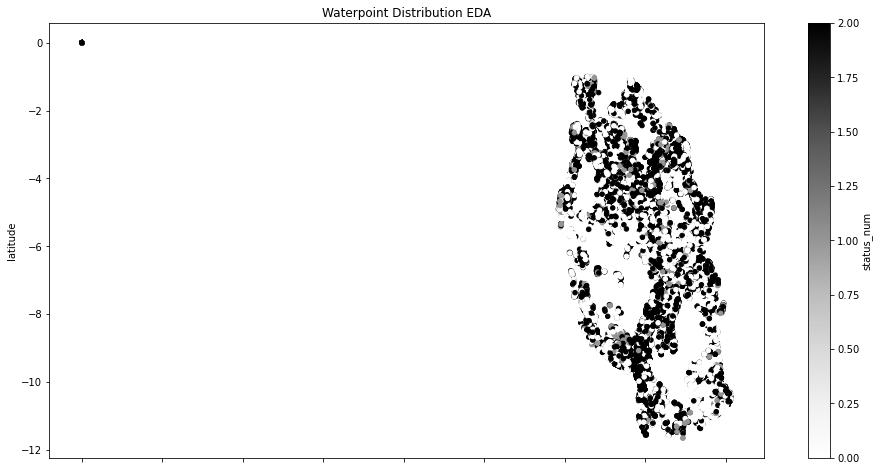

In [10]:
df_train['status_num'] = df_train['status_group'].map({'non functional': 0, 'functional needs repair': 1, 'functional': 2})
df_train.plot(kind="scatter", x="longitude", y="latitude", figsize=(16, 8), c='status_num');
plt.title("Waterpoint Distribution EDA")
plt.xlabel('longitude')
plt.show()
# appears to be an outlier, let's crop that out

In [11]:
display(df_train.loc[df_train['longitude']<25].head())
# it seems [0.0, -2.00] is a place holder for missing coordinate data for 1,812 rows.
display(df_train.loc[df_train['longitude']<25].shape)
len(df_train.loc[df_train['longitude']<25])/len(df_train)*100
# that is 3.5% of data

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,status_num
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.0,-2.000000e-08,Muungano,0,...,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Polisi,0,...,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,0
168,72678,0.0,2013-01-30,Wvt,0,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2
177,56725,0.0,2013-01-17,Netherlands,0,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,...,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional,0
253,13042,0.0,2012-10-29,Hesawa,0,DWE,0.0,-2.000000e-08,Kwakisusi,0,...,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,1


(1812, 42)

3.05050505050505

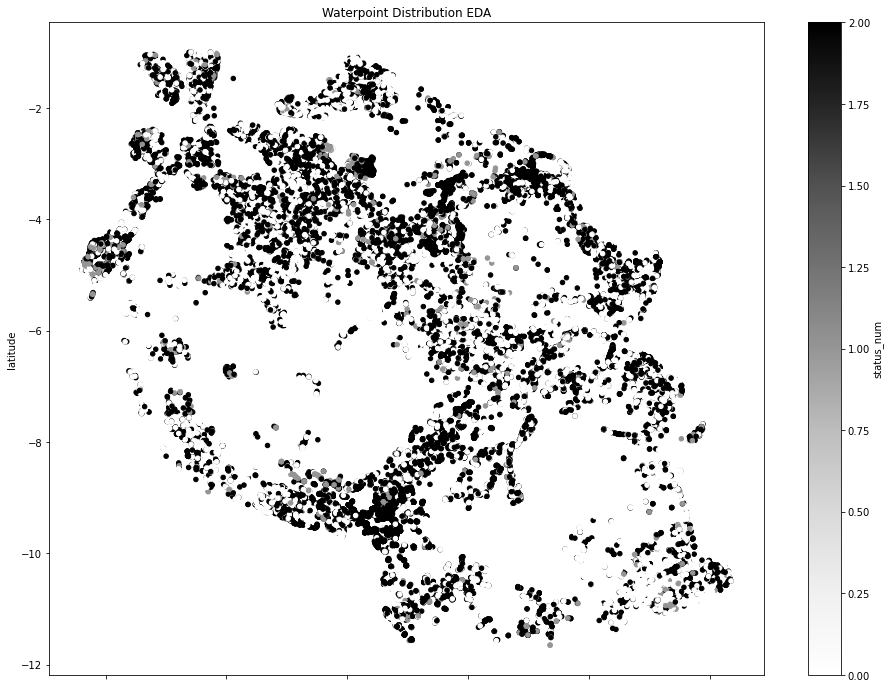

In [12]:
df_map = df_train.loc[df_train['longitude']>25]
df_map.plot(kind="scatter", x="longitude", y="latitude", figsize=(16, 12), c='status_num');
plt.title("Waterpoint Distribution EDA")
plt.xlabel('longitude')
plt.show()
# that looks more like Tanzania! Export!
# I prefer to used the verified/collected data for EDA mapping incase later imputed values are inaccurate
df_map.to_csv("../data/df_mappable.csv")

#### Missing Coordinate Data

Geographic placeholder values: 0.0, -2.00

From geographic data we do have in 'df_map', pull average long/lat coordinates from other geographic location data. In Tanzania there are 31 Regions, divided into 169 districts, divided into divisions and then into wards.

'region_code' has the 27 of 31 represented by tthe training set, it is also the most broad, so it is most likely to be present in incoming test data.

Create dictionaries of these average coordinates and 'pickle' for use in transforming the test set or incoming data later.


In [13]:
coord_dict_region = df_map.groupby('region_code').agg({'longitude': 'mean', 'latitude': 'mean'}).to_dict()
coord_dict_lga = df_map.groupby('lga').agg({'longitude': 'mean', 'latitude': 'mean'}).to_dict()

In [14]:
for i, row in df_train.iterrows():
    if df_train['longitude'][i] < 25:
        region = df_train['region_code'][i]
        df_train['longitude'][i] = coord_dict_region.get('longitude').get(region)
        df_train['latitude'][i] = coord_dict_region.get('latitude').get(region)

In [15]:
df_train['longitude'].value_counts() # check

33.244879    1057
33.091564     752
34.895027       3
37.542785       2
31.619530       2
             ... 
33.788326       1
37.371204       1
35.455622       1
34.628176       1
35.005922       1
Name: longitude, Length: 57518, dtype: int64

In [16]:
df_train['latitude'].value_counts() # check

-3.491473    1057
-2.620502     752
-8.904674       3
-6.965834       2
-6.964258       2
             ... 
-9.646831       1
-8.124530       1
-2.535985       1
-4.828176       1
-2.598965       1
Name: latitude, Length: 57519, dtype: int64

#### GPS Height/Altitude

According to [Nations Encyclopedia](https://www.nationsencyclopedia.com/geography/Slovenia-to-Zimbabwe-Cumulative-Index/Tanzania.html#ixzz6dRmSDzTg"), "Much of the country is above 900 meters (3,000 feet). A small portion, however, including the islands and the coastal plains, lies below about 200 meters (600 feet). The landscape is extremely varied, changing from coastal mangrove swamps to tropical rain forests and from rolling savannahs and high arid plateaus to mountain ranges."

In [17]:
gps_dict_region = df_map.groupby('region_code')['gps_height'].mean().astype('int64').to_dict()
gps_dict_district = df_map.groupby('district_code')['gps_height'].mean().astype('int64').to_dict()

In [18]:
for i, row in df_train.iterrows():
    region = df_train['region_code'][i]
    district = df_train['district_code'][i]
    # lowest point is sea level so neg. numbers are suspect
    if df_train['gps_height'][i] <= 0:
        df_train['gps_height'][i] = gps_dict_region.get(region)
    # fill in remaining wiht distict (less complete)
    if df_train['gps_height'][i] == 0:
        df_train['gps_height'][i] = gps_dict_district.get(district)

In [19]:
df_train['gps_height'].value_counts() # check for 0s

56      4875
191     2693
743     2543
861     2277
642     1976
        ... 
2566       1
2357       1
2261       1
2079       1
2327       1
Name: gps_height, Length: 2369, dtype: int64

#### Date/Time of Record

In [20]:
df_train['date_recorded'] = pd.to_datetime(df_train['date_recorded'])
df_train['year_rec'] = pd.DatetimeIndex(df_train['date_recorded']).year
df_train['month_rec'] = pd.DatetimeIndex(df_train['date_recorded']).month
print(f"Data range from {df_train['date_recorded'].min()} to {df_train['date_recorded'].max()}, roughly {4068/365} years.")

Data range from 2002-10-14 00:00:00 to 2013-12-03 00:00:00, roughly 11.145205479452056 years.


#### Construction Year / Age

According to World Bank Organization's [report](https://www.worldbank.org/en/results/2018/04/02/tanzania-investing-in-water-and-sanitation-reaps-benefits-for-poverty-alleviation), *Tanzania: Investing in Water and Sanitation Reaps Benefits for Poverty Alleviation* (APRIL 2, 2018), 35,908 water points were developed in program areas between 2005 and 2015.

The latest recorded date and well construction are both 2013.

I hesitate to use the *mean* construction year, 1997, or the *median*, 1986, because the missing values could potentially be from this expansion. Our test data only contains 13,365 water points from the range of the project.

In [35]:
year_prob_dict = df_train.loc[df_train['construction_year'] > 0, 'construction_year'].value_counts(normalize=True).to_dict()

In [36]:
def fill_construction_year(construction_year):
    if construction_year == 0:
        return np.random.choice(a=list(year_prob_dict.keys()), p=list(year_prob_dict.values()), replace=True)
    return construction_year

df_train['construction_year'] = df_train['construction_year'].apply(fill_construction_year)
df_train['construction_year'].value_counts()[0:10]

2008    4028
2010    4020
2009    3952
2000    3300
2007    2394
2006    2241
2003    1956
2011    1905
2004    1717
2012    1646
Name: construction_year, dtype: int64

In [38]:
df_train['age'] = df_train['year_rec'] - df_train['construction_year']

#### Population

Mean population for as small as geographic location as possible. Alternatively, I wondered if population '0' meant that a water point is located away from a living area and requires transport. For now, populating with mean of the district.

In [39]:
pop_dict_ward = df_train.groupby('ward')['population'].mean().astype('int64').to_dict()
pop_dict_district = df_train.groupby('district_code')['population'].mean().astype('int64').to_dict()

In [40]:
for i, row in df_train.iterrows():
    ward = df_train['ward'][i]
    district = df_train['district_code'][i]
    if df_train['population'][i] <= 0:
        df_train['population'][i] = pop_dict_ward.get(ward)
    if df_train['population'][i] <= 0:
        df_train['population'][i] = pop_dict_district.get(district)

In [41]:
display(df_train['population'].value_counts()) # check
df_train['population'].isna().sum()

1       7096
180     4027
182     3251
229     3249
132     2761
        ... 
471        1
2518       1
439        1
343        1
1439       1
Name: population, Length: 1056, dtype: int64

0

In [42]:
df_train.drop(columns=to_drop_numeric+['status_num'], inplace=True)
# keep 'id' for now in case of merging needs later

In [43]:
new_numeric = list(df_train.select_dtypes(np.number).columns)
new_numeric

['id',
 'gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_rec',
 'month_rec',
 'age']

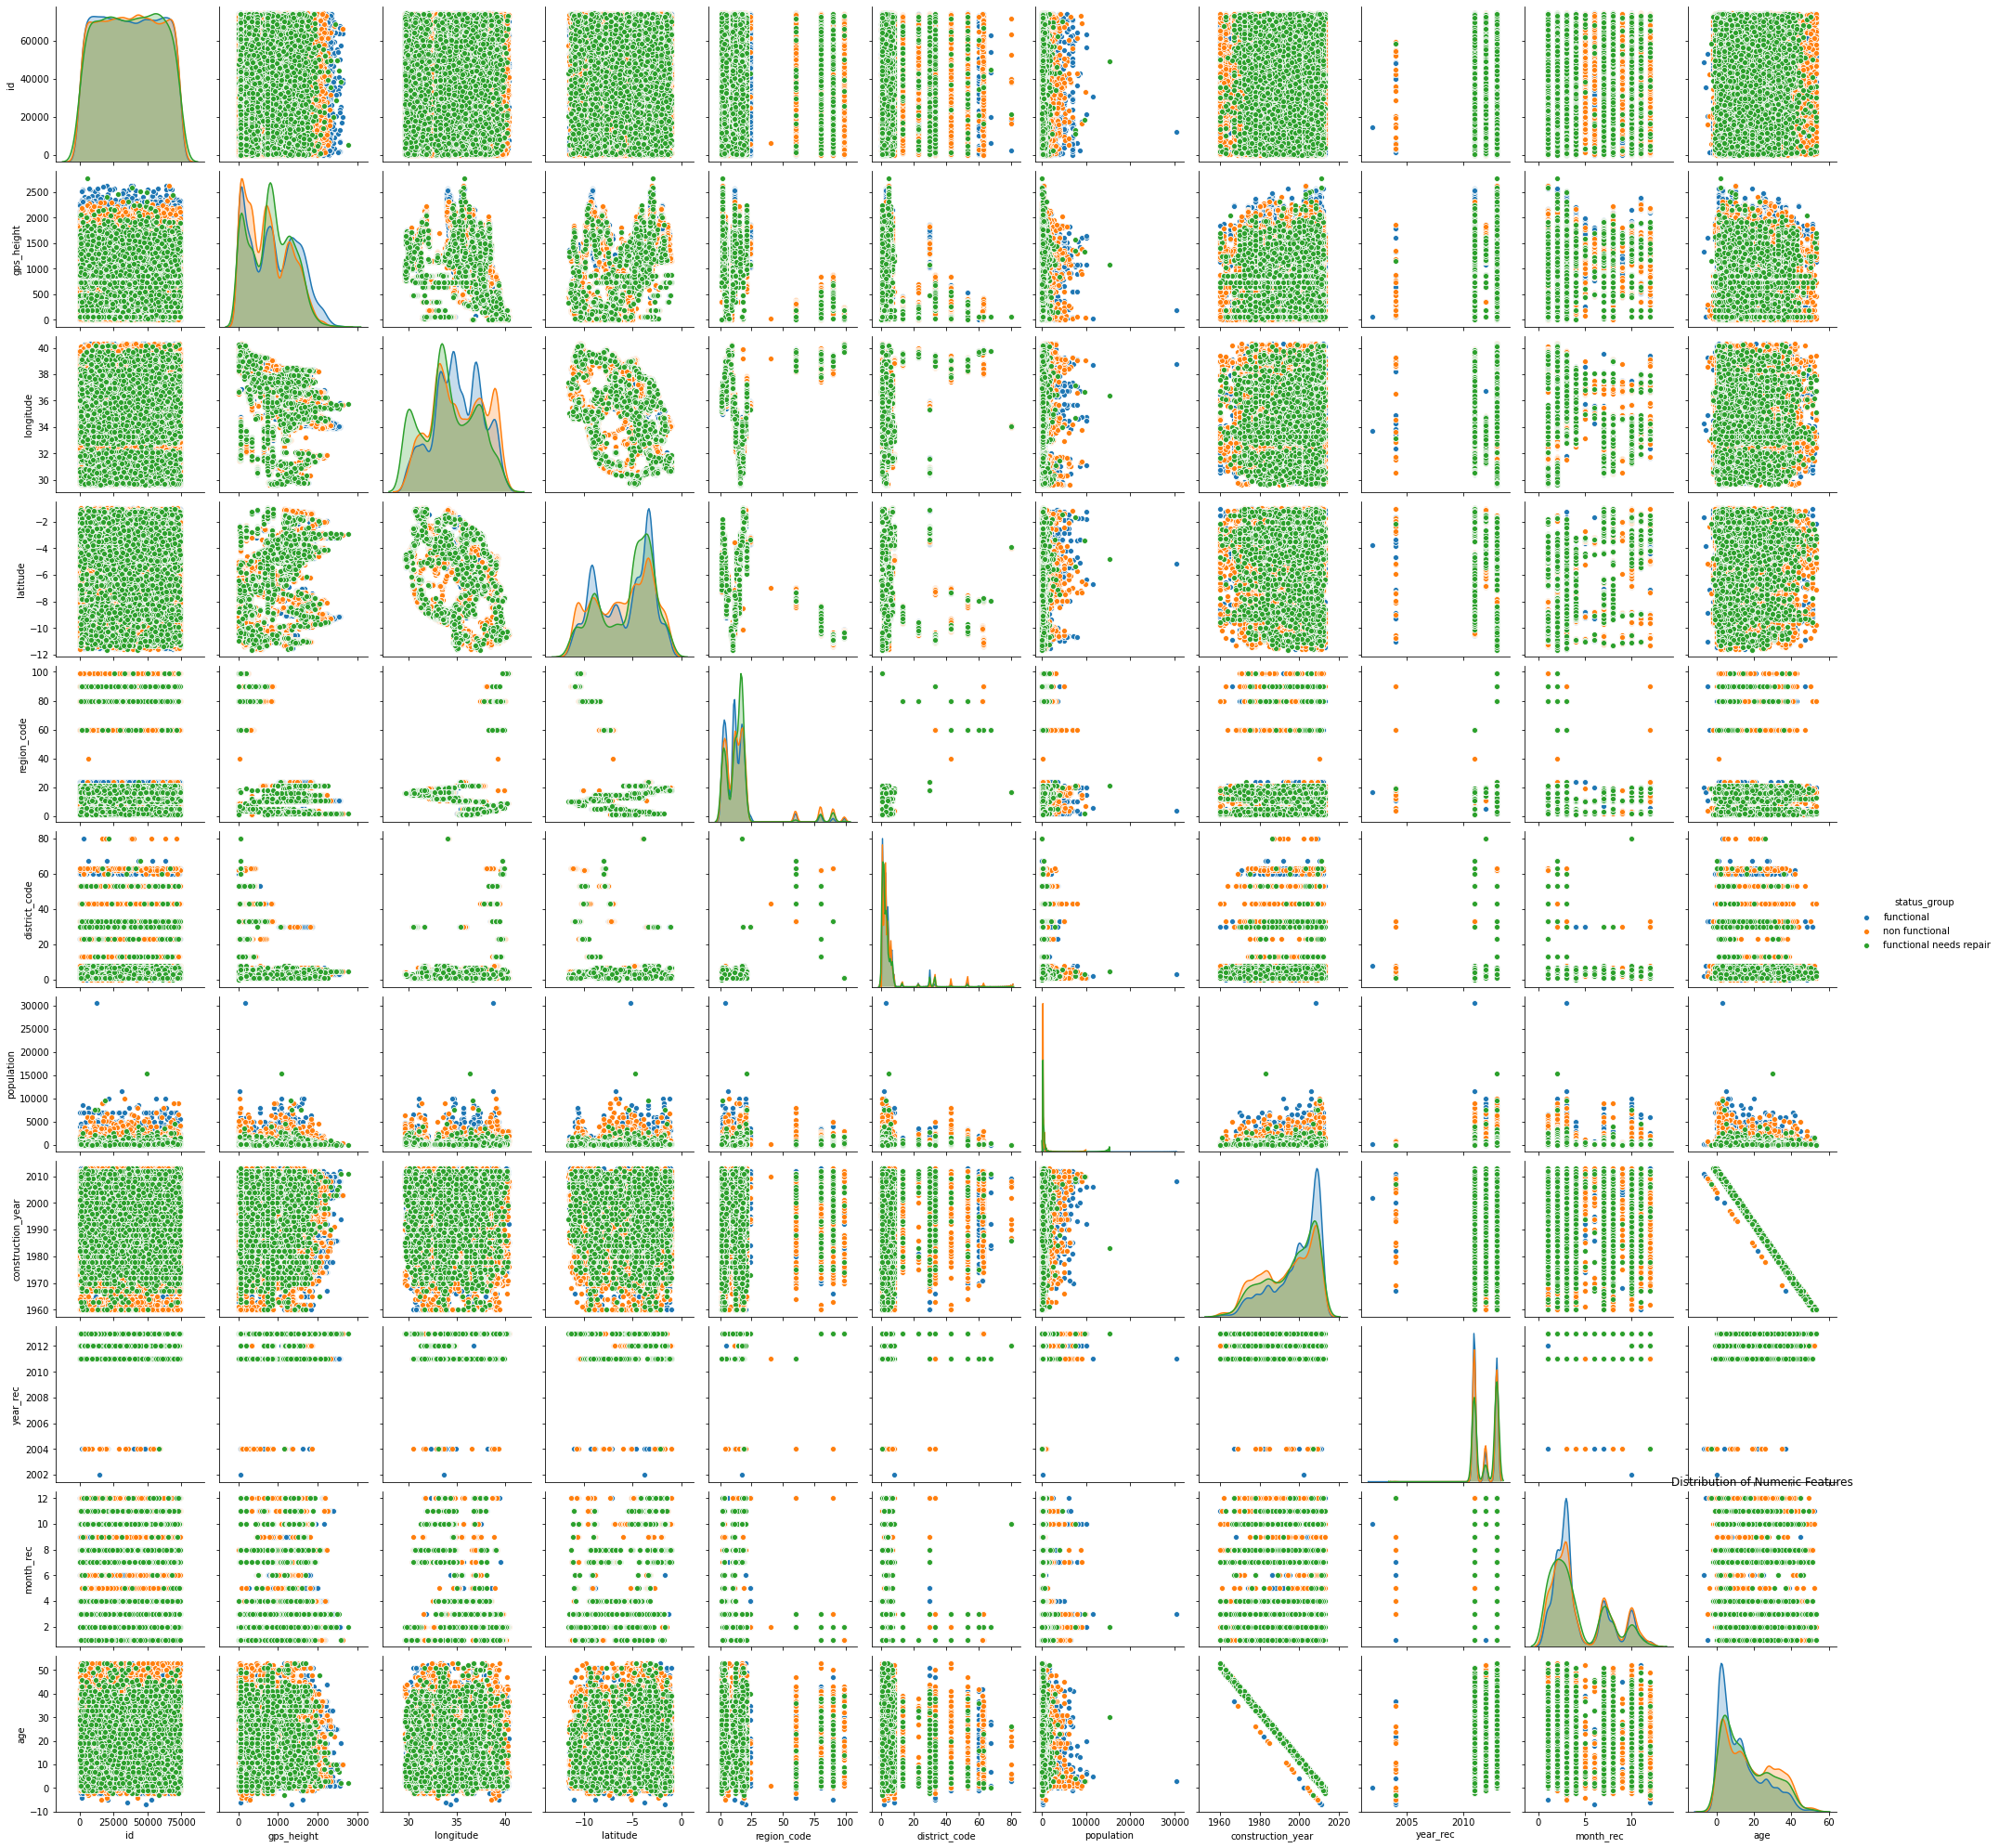

In [44]:
sns.pairplot(df_train[new_numeric+['status_group']], hue="status_group");
plt.title("Distribution of Numeric Features")
plt.show()

-------
### Categorical Distribution

In [45]:
# examine value counts for categorical
for col in X_training[categorical].columns:
    print(f"----- {col} -----")
    print(f"Unique: {X_training[col].nunique()}")
    display(X_training[col].value_counts()[0:15])

----- date_recorded -----
Unique: 356


2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
2011-03-18    497
2011-03-19    466
2013-02-04    464
2013-01-29    459
2011-03-04    458
2013-02-14    444
2013-01-24    435
2011-03-05    434
2013-02-15    429
2013-03-15    428
Name: date_recorded, dtype: int64

----- funder -----
Unique: 1897


Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
0                          777
Norad                      765
Name: funder, dtype: int64

----- installer -----
Unique: 2145


DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
Name: installer, dtype: int64

----- wpt_name -----
Unique: 37400


none               3563
Shuleni            1748
Zahanati            830
Msikitini           535
Kanisani            323
Bombani             271
Sokoni              260
Ofisini             254
School              208
Shule Ya Msingi     199
Shule               152
Sekondari           146
Muungano            133
Mkombozi            111
Madukani            104
Name: wpt_name, dtype: int64

----- basin -----
Unique: 9


Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

----- subvillage -----
Unique: 19287


Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
Sokoni        232
M             187
Muungano      172
Mbuyuni       164
Mlimani       152
Songambele    147
Miembeni      134
Msikitini     134
1             132
Kibaoni       114
Name: subvillage, dtype: int64

----- region -----
Unique: 21


Iringa         5294
Shinyanga      4982
Mbeya          4639
Kilimanjaro    4379
Morogoro       4006
Arusha         3350
Kagera         3316
Mwanza         3102
Kigoma         2816
Ruvuma         2640
Pwani          2635
Tanga          2547
Dodoma         2201
Singida        2093
Mara           1969
Name: region, dtype: int64

----- lga -----
Unique: 125


Njombe           2503
Arusha Rural     1252
Moshi Rural      1251
Bariadi          1177
Rungwe           1106
Kilosa           1094
Kasulu           1047
Mbozi            1034
Meru             1009
Bagamoyo          997
Singida Rural     995
Kilombero         959
Same              877
Kibondo           874
Kyela             859
Name: lga, dtype: int64

----- ward -----
Unique: 2092


Igosi           307
Imalinyi        252
Siha Kati       232
Mdandu          231
Nduruma         217
Kitunda         203
Mishamo         203
Msindo          201
Chalinze        196
Maji ya Chai    190
Usuka           187
Ngarenanyuki    172
Chanika         171
Vikindu         162
Mtwango         153
Name: ward, dtype: int64

----- public_meeting -----
Unique: 2


True     51011
False     5055
Name: public_meeting, dtype: int64

----- recorded_by -----
Unique: 1


GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

----- scheme_management -----
Unique: 12


VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

----- scheme_name -----
Unique: 2696


K                                        682
None                                     644
Borehole                                 546
Chalinze wate                            405
M                                        400
DANIDA                                   379
Government                               320
Ngana water supplied scheme              270
wanging'ombe water supply s              261
wanging'ombe supply scheme               234
I                                        229
Bagamoyo wate                            229
Uroki-Bomang'ombe water sup              209
N                                        204
Kirua kahe gravity water supply trust    193
Name: scheme_name, dtype: int64

----- permit -----
Unique: 2


True     38852
False    17492
Name: permit, dtype: int64

----- extraction_type -----
Unique: 18


gravity              26780
nira/tanira           8154
other                 6430
submersible           4764
swn 80                3670
mono                  2865
india mark ii         2400
afridev               1770
ksb                   1415
other - rope pump      451
other - swn 81         229
windmill               117
india mark iii          98
cemo                    90
other - play pump       85
Name: extraction_type, dtype: int64

----- extraction_type_group -----
Unique: 13


gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

----- extraction_type_class -----
Unique: 7


gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

----- management -----
Unique: 12


vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

----- management_group -----
Unique: 5


user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

----- payment -----
Unique: 7


never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

----- payment_type -----
Unique: 7


never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

----- water_quality -----
Unique: 8


soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

----- quality_group -----
Unique: 6


good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

----- quantity -----
Unique: 5


enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

----- quantity_group -----
Unique: 5


enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

----- source -----
Unique: 10


spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

----- source_type -----
Unique: 7


spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

----- source_class -----
Unique: 3


groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

----- waterpoint_type -----
Unique: 7


communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

----- waterpoint_type_group -----
Unique: 6


communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

To maximize information gain at each categorical boundary, having the fewest/easiest to segregate categories helps. I will parse through categorical features and select those with most concise information.

- 'wpt_name' has 37,400 unique, with top 10 occurances (8,191) as:

        In Swahili:
        Shuleni - School (or variations of)
        Zahanati - Dispensary
        Msikitini - Mosque
        Kanisani - Church
        Sokoni - Market
        Ofisini - Office

        While the precise location of the water point may contibute to its access and maintenance, 
        a category this expansive has little predictive power and will be dropped
        
- 'recorded_by' has only one category (GeoData consuoltants Ltd) and thus can be dropped
- 'waterpoint_type_group' is almost identical to 'waterpoint_type', the later is smore specific by 1, thus keeping later
- 'quantity', 'quality', 'payment_type' have an almost duplicate corresponding 'group' feature. Only one from each pair will be kept.
- 'scheme_name' has 2696 unique types, 'scheme_managment' groups them into 12 groups, keeping in simple 
- 'public_meeting' and 'permit' are True/False and can be converted to binary Boolean
- 'date_recorded' is of no use to classifying, but will be kept to calculate the age of the pump and dropped later
- 'funder' and 'installer' have roughly 2,000 unique values *each*. These features could have significant predictive power to the quality and durability of the pump. However, this range of values will not be useful to the model. Future work would be to group these into smaller categories that can make sense of information. They will be dropped from this analysis.
- 'extraction_type' data is available in 3 tiers of information, expanding in this order: class (7), group (13), and type (18). I choose to keep most condensed 'class' feature, as the others continue to expand the various hand pumps into small categories in the hundreds. With 59,000 total entries in the data set this expansion gives little predictive power.
- locatation information:
    
        'ward' (2,092) - drop
        'region' (21) - compare to the 21 'region_code'(s) in numeric category
        'basin' (9) - compare to similar in numeric, deciding to keep this and 'region' incase of missing data
        'lga' (125) - transform into 'urban', 'rural', and 'other'
        'subvillage' (~20,000 unique) - drop
        

In [46]:
# dimensionality reduction by dropping redundant features
# add 'date_recorded' to drop list
to_drop_cats = ['date_recorded', 'recorded_by', 'waterpoint_type_group', 'quantity_group', 
                   'quality_group', 'payment_type', 'management_group', 'scheme_name', 'wpt_name',
                   'funder', 'installer', 'extraction_type', 'extraction_type_class', 'subvillage',
                   'ward', 'source_class', 'source_type']

boolean = ['permit', 'public_meeting']

### Null Values

For categorical columns, all the listed NaN's are in columns to bee dropped except 'scheme_management', 'public_meeting', and 'permit'.

In [47]:
df_train[categorical].isna().sum()

date_recorded                0
funder                    3635
installer                 3655
wpt_name                     0
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
dtype: int64

#### Scheme Management

For now, NaN repalced with 'unknown'.

In [48]:
df_train['scheme_management'].fillna(value='unknown', inplace=True)
df_train['scheme_management'].isna().sum() # check

0

#### Permit and Public Meeting

'permit' and 'public_meeting' are both True/False. I will replace Null values with False and then convert to binary 1/0. My assumption is that these NaN's represent a lack of data. While data may exist but was just unavailble at time of input, I made the call: If no data was found that there exisits a permit or there was a meeting, it is likely neither is True/present.

In [49]:
# check for Null in boolean set
print("Check for Null:",[(df_train[x].isna().sum()) for x in boolean])

# Fill missing values with '0' while converting to numeric
for col in boolean:
    df_train[col].fillna(False, inplace=True)
    df_train[col].astype(int)
    print(f"Value counts: {col} \n {df_train[col].value_counts()} \n -------")
    print("Sum:", df_train[col].value_counts().sum())

print("Check for Null:",[df_train[x].isna().sum() for x in boolean])   

Check for Null: [3056, 3334]
Value counts: permit 
 True     38852
False    20548
Name: permit, dtype: int64 
 -------
Sum: 59400
Value counts: public_meeting 
 True     51011
False     8389
Name: public_meeting, dtype: int64 
 -------
Sum: 59400
Check for Null: [0, 0]


#### LGA (Local Government Authority)
Check how dividing 'lga' (Local Goverment Authority) into subtypes: urban, rural, other; can reduce dimentionality for the model.

In [50]:
for i, lga in enumerate(df_train['lga']):
    item = lga.lower()
    if 'rural' in item:
        df_train['lga'][i] = 'rural'
        continue
    if 'urban' in item:
        df_train['lga'][i] = 'urban'
    else:
        df_train['lga'][i] = 'other'

In [51]:
df_train['lga'].value_counts() # check

other    48165
rural     9552
urban     1683
Name: lga, dtype: int64

### Drop Categories

In [52]:
df_train.drop(columns=to_drop_cats, inplace=True)

In [53]:
to_encode = list(df_train.select_dtypes('object').columns)[:-1] # drop target from end
to_encode

['basin',
 'region',
 'lga',
 'scheme_management',
 'extraction_type_group',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type']

-----

### Export Cleaned Data

Data has been cleaned. Cleaning functions built. Save and export for use in model building.

In [54]:
df_train.info() # no Nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   gps_height             59400 non-null  int64  
 2   longitude              59400 non-null  float64
 3   latitude               59400 non-null  float64
 4   basin                  59400 non-null  object 
 5   region                 59400 non-null  object 
 6   region_code            59400 non-null  int64  
 7   district_code          59400 non-null  int64  
 8   lga                    59400 non-null  object 
 9   population             59400 non-null  int64  
 10  public_meeting         59400 non-null  bool   
 11  scheme_management      59400 non-null  object 
 12  permit                 59400 non-null  bool   
 13  construction_year      59400 non-null  int64  
 14  extraction_type_group  59400 non-null  object 
 15  ma

In [55]:
(df_train[new_numeric] == 0).sum() # looks good, remaining zeros are ok

id                      1
gps_height             23
longitude               0
latitude                0
region_code             0
district_code          23
population             35
construction_year       0
year_rec                0
month_rec               0
age                  1169
dtype: int64

In [56]:
df_train.to_csv("../data/cleaned_train_df.csv", index=False)

In [57]:
# pickle dicts with training data means for use in transforming missing data in test sets:
f = open("../data/mean_dicts.pkl", "wb")
pickle.dump(coord_dict_region, f)
pickle.dump(coord_dict_lga, f)
pickle.dump(gps_dict_region, f)
pickle.dump(gps_dict_district, f)
pickle.dump(pop_dict_ward, f)
pickle.dump(pop_dict_district, f)
pickle.dump(year_prob_dict, f)
f.close()

In [58]:
### Copy/paste this to import the pickled dicts
# f = open("../data/mean_dicts.pkl", 'rb')
# coord_dict_region = pickle.load(f)
# coord_dict_lga = pickle.load(f)
# gps_dict_region = pickle.load(f)
# gps_dict_district = pickle.load(f)
# pop_dict_ward = pickle.load(f)
# pop_dict_district = pickle.load(f)
# year_prob_dict = pickle.load(f)
# f.close()